# Content-based Recommender System

In [20]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import json

from surprise import Dataset, Reader
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Data Loading
photos_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/photos.csv', sep=',', encoding='latin-1',low_memory=False)
ratings_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/ratings.csv', sep=',', encoding='latin-1',low_memory=False)
surveys_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/surveys.csv', sep=',', encoding='latin-1',low_memory=False)
annotations_df = pd.read_csv('C:/Users/lmir/Desktop/Tese/Results_sim/emorecsys_data/CSVs_8_7_2024/csvs_survey/annotations.csv', sep=',', encoding='latin-1',low_memory=False)

In [5]:
photos_df

,id,file_name,ext,views,id_source,source,height,width,alt
0,1,iaps_mikels_annotated-1019,jpg,0,1019,iaps_mikels_annotated,NaN,NaN,NaN
1,2,iaps_mikels_annotated-1022,jpg,11,1022,iaps_mikels_annotated,NaN,NaN,NaN
2,3,iaps_mikels_annotated-1030,jpg,0,1030,iaps_mikels_annotated,NaN,NaN,NaN
3,4,iaps_mikels_annotated-1040,jpg,0,1040,iaps_mikels_annotated,NaN,NaN,NaN
4,5,iaps_mikels_annotated-1050,jpg,0,1050,iaps_mikels_annotated,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2880,3079,pexels-photo-19221067,jpeg,0,19221067,pexels,4000.0,6000.0,A black and white photo of a tank
2881,3081,pexels-photo-53442,jpeg,0,53442,pexels,2352.0,3515.0,Black Metal Train Rails
2882,3082,pexels-photo-1636162,jpeg,0,1636162,pexels,3167.0,4781.0,Brown Concrete Building
2883,3083,pexels-photo-1643166,jpeg,0,1643166,pexels,2986.0,4508.0,Leafless Trees Near the Building


In [28]:
ratings_df

,id,id_photo,id_survey,like_bool,anger,fear,disgust,sadness,happiness,surprise,neutral,valence,arousal,dominance
0,1,1754,1,1,0,0,0,0,0,0,5,3,1,2
1,2,1785,1,1,0,0,0,2,0,0,0,2,2,3
2,3,123,1,0,0,0,0,4,0,0,0,1,3,1
3,4,2315,1,0,0,0,0,2,0,0,0,2,1,3
4,5,1548,1,0,0,0,0,0,0,0,5,3,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,2441,2546,163,0,0,5,0,5,0,0,0,1,5,1
2441,2442,2097,163,0,0,0,3,0,5,0,0,2,2,1
2442,2443,1898,163,0,0,0,3,5,0,1,0,1,4,1
2443,2444,1871,163,0,0,0,0,5,0,0,0,1,1,1


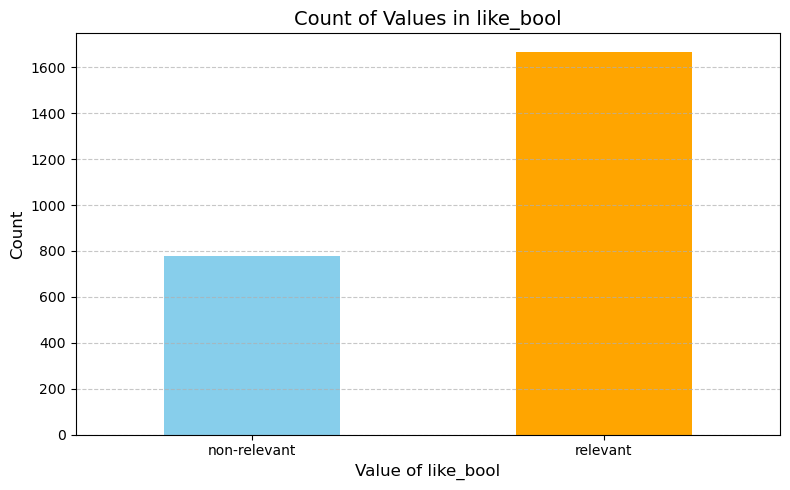

In [31]:
like_bool_counts = ratings_df['like_bool'].value_counts()
like_bool_counts = like_bool_counts.sort_index()


plt.figure(figsize=(8, 5))
like_bool_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Count of Values ​​in like_bool', fontsize=14)
plt.xlabel('Value of like_bool', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['non-relevant', 'relevant'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

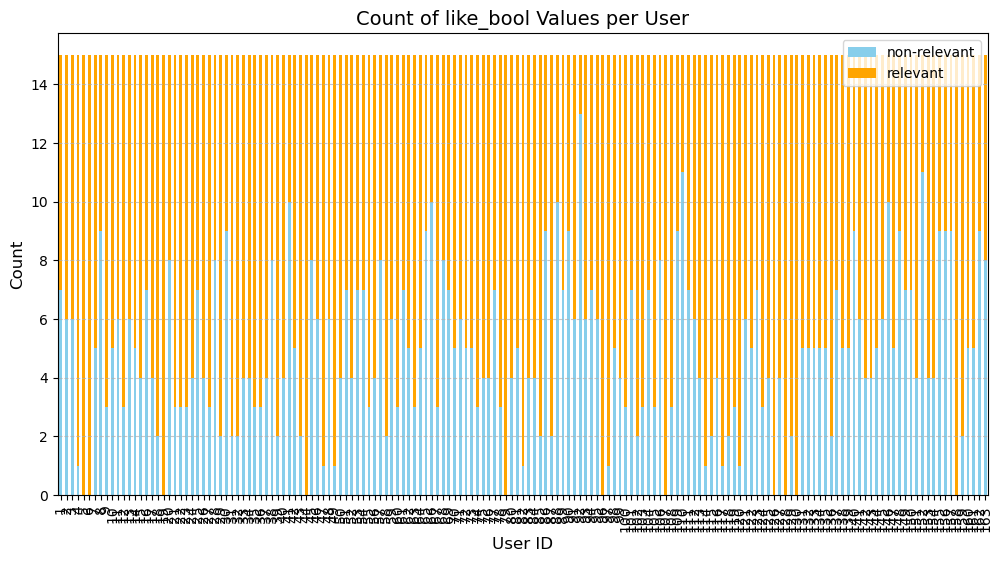

In [34]:
like_bool_counts_by_user = ratings_df.groupby('id_survey')['like_bool'].value_counts().unstack(fill_value=0)

# Plotar o gráfico
plt.figure(figsize=(12, 6))

# Plotando o gráfico de barras
like_bool_counts_by_user.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], ax=plt.gca())

# Customizações
plt.title('Count of like_bool Values per User', fontsize=14)
plt.xlabel('User ID', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)  # Rótulos dos usuários no eixo x
plt.legend(['non-relevant', 'relevant'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.tight_layout

## Pre-processing - Splits

In [6]:
def split_emorecsys(dataset, train=0.8, test=0.2):
    """Divides the dataset in train and test set for each user. Assuring that the test set has at least one
    item that the user liked and one that the user disliked.

    Args:
        dataset (_type_): _description_
        train (float, optional): portion size for the test set. Defaults to 0.8.
        test (float, optional): portion size for the test set. Defaults to 0.2.

    Raises:
        ValueError: It raises an error when the user doesn't have at least one relevant evaluation

    Returns:
        tuple: contains the train and test sets that are a lists of tuples (uid, iid, rating).
    """
    trainset, testset = list(), list()
    user_unilked_any = []

    for user in list(set(dataset['id_survey'])):
        user_ratings = dataset[dataset['id_survey'] == user]
        all_ratings = list((user, id_photo, like_bool) for id_photo, like_bool in zip(user_ratings['id_photo'], user_ratings['like_bool']))
        size_ratings = len(all_ratings)

        user_trainset = []

        # Selects the relevant ratings (like_bool = 1) and the not relevant (like_bool = 0)
        relevant = list(x for x in all_ratings if x[2] == 1)
        not_relevant = list(x for x in all_ratings if x[2] == 0)

        user_testset = []

        if relevant:  # if the user has one relevant rating
            new_rating = random.sample(relevant, 1)
            user_testset.extend(new_rating)
        else:
            raise ValueError('The user ' + str(user) + ' did not like any photo')

        if not_relevant:  # If the user has a not relevant rating
            new_rating = random.sample(not_relevant, 1)
            user_testset.extend(new_rating)
        else:
            user_unilked_any.append(user)
        
        remaining_ratings = [x for x in all_ratings if x not in user_testset]
        random.shuffle(remaining_ratings)

        while len(user_testset) < int(size_ratings * test):
            new_rating = remaining_ratings.pop(0)
            if new_rating not in user_testset:
                user_testset.append(new_rating)

        user_trainset = [x for x in all_ratings if x not in user_testset]

        trainset.extend(user_trainset)
        testset.extend(user_testset)

        expected_test_size = int(size_ratings * test)
        expected_train_size = int(size_ratings * train) 

        assert len(user_testset) == expected_test_size
        assert len(user_trainset) == expected_train_size

    return trainset, testset

In [7]:
trainset, testset = split_emorecsys(ratings_df)

In [10]:
print(trainset)
print(testset)

[(1, 1754, 1), (1, 1785, 1), (1, 123, 0), (1, 2315, 0), (1, 1548, 0), (1, 1738, 1), (1, 2922, 1), (1, 986, 0), (1, 1142, 1), (1, 889, 0), (1, 1059, 1), (1, 1507, 1), (2, 1778, 1), (2, 379, 0), (2, 1898, 0), (2, 2121, 1), (2, 2370, 1), (2, 25, 0), (2, 991, 0), (2, 2234, 0), (2, 544, 1), (2, 1621, 1), (2, 40, 1), (2, 2211, 1), (3, 316, 0), (3, 1569, 1), (3, 748, 1), (3, 2482, 0), (3, 2144, 1), (3, 1927, 0), (3, 2184, 1), (3, 235, 0), (3, 1407, 1), (3, 655, 1), (3, 675, 1), (3, 1295, 1), (4, 2661, 1), (4, 1082, 1), (4, 1710, 1), (4, 2053, 1), (4, 766, 1), (4, 2933, 1), (4, 494, 1), (4, 1665, 1), (4, 2073, 1), (4, 1816, 1), (4, 2395, 1), (4, 1358, 1), (5, 2717, 1), (5, 749, 1), (5, 99, 1), (5, 158, 1), (5, 1251, 1), (5, 2734, 1), (5, 1686, 1), (5, 193, 1), (5, 2347, 1), (5, 2067, 1), (5, 498, 1), (5, 2897, 1), (6, 1730, 1), (6, 1308, 1), (6, 3054, 1), (6, 1442, 1), (6, 546, 1), (6, 1251, 1), (6, 2143, 1), (6, 2940, 1), (6, 1513, 1), (6, 2581, 1), (6, 2416, 1), (6, 1627, 1), (7, 1461, 1), (

In [ ]:
df_trainset = pd.DataFrame(trainset, columns=['user_id', 'item_id', 'rating'])
df_trainset.to_csv('trainset.csv', index=False)

df_testset = pd.DataFrame(testset, columns=['user_id', 'item_id', 'rating'])
df_testset.to_csv('testset.csv', index=False)

In [17]:
testset = pd.read_csv('C:/Users/lmir/Desktop/Tese/EmoRecSys/data/csvs/testset.csv')
trainset = pd.read_csv('C:/Users/lmir/Desktop/Tese/EmoRecSys/data/csvs/trainset.csv')

testset = [tuple(row) for row in testset.to_numpy()]
trainset = [tuple(row) for row in trainset.to_numpy()]

print(testset)
print(trainset)

[(1, 1738, 1), (1, 318, 0), (1, 1055, 1), (2, 40, 1), (2, 1898, 0), (2, 544, 1), (3, 675, 1), (3, 235, 0), (3, 1295, 1), (4, 2901, 1), (4, 1250, 0), (4, 1082, 1), (5, 1717, 1), (5, 2717, 1), (5, 2897, 1), (6, 1251, 1), (6, 2143, 1), (6, 546, 1), (7, 429, 1), (7, 2877, 0), (7, 2195, 1), (8, 38, 1), (8, 2516, 0), (8, 1925, 0), (9, 1839, 1), (9, 2677, 0), (9, 1543, 1), (10, 2738, 1), (10, 3059, 0), (10, 2892, 1), (11, 1255, 1), (11, 2002, 0), (11, 1612, 0), (12, 1235, 1), (12, 2876, 0), (12, 2099, 1), (13, 2474, 1), (13, 2684, 0), (13, 155, 0), (14, 2533, 1), (14, 857, 0), (14, 2736, 0), (15, 1312, 1), (15, 2390, 0), (15, 407, 1), (16, 215, 1), (16, 1335, 0), (16, 205, 1), (17, 530, 1), (17, 3057, 0), (17, 791, 1), (18, 1737, 1), (18, 954, 0), (18, 1156, 1), (19, 980, 1), (19, 98, 1), (19, 3004, 1), (20, 1429, 1), (20, 1861, 0), (20, 567, 1), (21, 584, 1), (21, 853, 0), (21, 2792, 1), (22, 1428, 1), (22, 365, 0), (22, 724, 1), (23, 634, 1), (23, 534, 0), (23, 1315, 1), (24, 1683, 1), (24,

In [18]:
def random_sample(trainset, testset):

    train_df = pd.DataFrame(trainset, columns=['uid', 'iid', 'rating'])
    test_df = pd.DataFrame(testset, columns=['uid', 'iid', 'rating'])

    items_all_ids = set(train_df['iid'].to_list() + test_df['iid'].to_list())
    
    user_random_items = {}


    for user in test_df['uid'].unique():

        user_train = train_df[train_df['uid'] == user]
        user_test = test_df[test_df['uid'] == user]

        train_item_ids = user_train['iid'].to_list()
        test_item_ids = user_test['iid'].to_list()

        available_items = list(items_all_ids - set(train_item_ids) - set(test_item_ids)) # todos os items menos os do 
        random_items = random.sample(available_items, 20)

        if len(available_items) >= 20:
            random_items = random.sample(available_items, 20)
        else:
            random_items = available_items 

        user_random_items[user] = random_items

    return user_random_items

In [24]:
def save_to_json(data, file_name):
    with open(file_name, 'w') as json_file:
        json.dump({int(key): value for key, value in data.items()}, json_file, indent=4)
    print(f"JSON saved in: {file_name}")

In [26]:
user_random_items = random_sample(trainset, testset)
print(user_random_items)


save_to_json(user_random_items, 'random_items_per_user.json')

{1: [599, 748, 208, 1725, 6, 1327, 474, 2811, 2184, 1335, 3041, 2691, 2030, 2211, 80, 38, 3016, 1315, 1415, 530], 2: [1038, 1922, 2303, 689, 2998, 1521, 559, 1548, 2095, 414, 2143, 2661, 1427, 2811, 1818, 2, 925, 2516, 2533, 316], 3: [2920, 1665, 3009, 2695, 99, 2288, 2796, 2787, 736, 2306, 1388, 2630, 208, 2668, 767, 480, 1362, 14, 2723, 364], 4: [2556, 1586, 453, 1300, 1821, 2673, 1550, 2481, 400, 1946, 2654, 2502, 1645, 857, 689, 2014, 2234, 864, 2995, 1044], 5: [953, 2206, 887, 544, 2211, 2951, 2447, 2, 530, 278, 123, 996, 2894, 1642, 2691, 155, 861, 1979, 2957, 2581], 6: [2447, 3032, 2882, 2745, 2848, 1415, 2258, 1487, 155, 615, 166, 2457, 2405, 2046, 1502, 559, 1302, 2895, 1201, 1300], 7: [2396, 2621, 1821, 2552, 1327, 993, 1940, 969, 2695, 732, 2121, 2751, 1621, 2882, 1982, 481, 612, 2315, 2989, 2717], 8: [498, 1044, 2111, 2594, 1818, 567, 748, 724, 1246, 1323, 2409, 1554, 1853, 148, 1461, 453, 1975, 2098, 1757, 953], 9: [1621, 644, 750, 1522, 1315, 567, 2087, 1342, 1352, 861, 3

# Pre-processing Pixel-based

## VGG16

In [41]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image

vgg16 = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))

for model_layer in vgg16.layers:
    model_layer.trainable = False

def load_and_preprocess_image(image_path):
    input_image = Image.open(image_path)
    resized_image = input_image.resize((224, 224))
    image_array = np.expand_dims(image.img_to_array(resized_image), axis=0)
    preprocessed_image = preprocess_input(image_array)
    return preprocessed_image

def get_image_embeddings(image_array):
    return vgg16.predict(image_array)

imgs_path = "C:/Users/lmir/Desktop/Tese/EmoRecSys/data/photos"

def compute_embeddings(imgs_path, df_views_filtered, extensions=(".jpg", ".jpeg", ".png")):
    if not os.path.exists(imgs_path):
        raise FileNotFoundError(f"O diretório especificado não existe: {imgs_path}")
    
    files = [os.path.join(imgs_path, f) for f in os.listdir(imgs_path) if f.lower().endswith(extensions)]
    
    image_embeddings = []
    
    for file_path in files:
        filename_with_ext = os.path.basename(file_path)
        filename, file_ext = os.path.splitext(filename_with_ext)
        if filename in df_views_filtered['file_name'].values: 
            image_array = load_and_preprocess_image(file_path)
            embeddings = get_image_embeddings(image_array)
            image_embeddings.append({'filename': filename, 'embedding': embeddings})
    
    df_embeddings = pd.DataFrame(image_embeddings)
    
    return df_embeddings

df_embeddings_vgg16 = compute_embeddings(imgs_path, photos_df)

1/1 [==============================] - 1s 650ms/step


In [42]:
df_embeddings_vgg16['file_name'] = df_embeddings_vgg16['filename']
df_embeddings_vgg16 = pd.merge(df_embeddings_vgg16, photos_df, on='file_name', how='left')
df_embeddings_vgg16 = df_embeddings_vgg16.drop(columns=["filename", "file_name", "ext", "views", "id_source", "source", "height", "width", "alt"])

In [43]:
df_embeddings_vgg16.to_csv('embeddings_vgg16.csv', index=False)

In [44]:
df_embeddings_vgg16.to_json('df_embeddings_vgg16.json', orient='records', lines=True)

## VGG19

In [45]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image

vgg19 = VGG19(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))

for model_layer in vgg19.layers:
    model_layer.trainable = False

def load_and_preprocess_image(image_path):
    input_image = Image.open(image_path)
    resized_image = input_image.resize((224, 224))
    image_array = np.expand_dims(image.img_to_array(resized_image), axis=0)
    preprocessed_image = preprocess_input(image_array)
    return preprocessed_image

def get_image_embeddings(image_array):
    return vgg19.predict(image_array)

imgs_path = "C:/Users/lmir/Desktop/Tese/EmoRecSys/data/photos"

def compute_embeddings(imgs_path, df_views_filtered, extensions=(".jpg", ".jpeg", ".png")):
    if not os.path.exists(imgs_path):
        raise FileNotFoundError(f"O diretório especificado não existe: {imgs_path}")
    
    files = [os.path.join(imgs_path, f) for f in os.listdir(imgs_path) if f.lower().endswith(extensions)]
    
    image_embeddings = []
    
    for file_path in files:
        filename_with_ext = os.path.basename(file_path)
        filename, file_ext = os.path.splitext(filename_with_ext)
        if filename in df_views_filtered['file_name'].values: 
            image_array = load_and_preprocess_image(file_path)
            embeddings = get_image_embeddings(image_array)
            image_embeddings.append({'filename': filename, 'embedding': embeddings})
    
    df_embeddings = pd.DataFrame(image_embeddings)
    
    return df_embeddings

df_embeddings_vgg19 = compute_embeddings(imgs_path, photos_df)

# print(df_embeddings_vgg19)

1/1 [==============================] - 1s 1s/step


In [46]:
df_embeddings_vgg19

,filename,embedding
0,amazing-beautiful-beauty-blue,"[[30.999668, 0.0, 13.365301, 0.0, 20.36036, 3...."
1,amazing-beautiful-breathtaking-clouds,"[[30.757627, 24.759487, 0.0, 0.0, 58.784, 7.51..."
2,iaps_mikels_annotated-1019,"[[62.916016, 17.973776, 49.714672, 1.4103657, ..."
3,iaps_mikels_annotated-1022,"[[45.739323, 0.0, 117.1519, 0.0, 13.339963, 12..."
4,iaps_mikels_annotated-1030,"[[11.106704, 51.90667, 15.168107, 0.0, 0.0, 0...."
...,...,...
2880,pexels-photo-992731,"[[8.859455, 19.083033, 24.789968, 0.0, 2.22690..."
2881,pexels-photo-992816,"[[57.390045, 0.0, 0.0, 11.2949505, 3.2793827, ..."
2882,pexels-photo-9969541,"[[25.547699, 105.25643, 45.114285, 19.818699, ..."
2883,pexels-photo-9969543,"[[16.461166, 55.15842, 20.131643, 0.0, 15.3487..."


In [47]:
df_embeddings_vgg19['file_name'] = df_embeddings_vgg19['filename']
df_embeddings_vgg19 = pd.merge(df_embeddings_vgg19, photos_df, on='file_name', how='left')
df_embeddings_vgg19 = df_embeddings_vgg19.drop(columns=["filename", "file_name", "ext", "views", "id_source", "source", "height", "width", "alt"])

In [48]:
df_embeddings_vgg19.to_csv('embeddings_vgg19.csv', index=False)
df_embeddings_vgg19.to_json('df_embeddings_vgg19.json', orient='records', lines=True)

## ResNet50 & ResNet50v2

In [6]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from PIL import Image

resnet50 = ResNet50(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))


for model_layer in resnet50.layers:
    model_layer.trainable = False


def load_and_preprocess_image(image_path):
    input_image = Image.open(image_path)
    resized_image = input_image.resize((224, 224)) 
    image_array = np.expand_dims(image.img_to_array(resized_image), axis=0)  
    preprocessed_image = preprocess_input(image_array)  
    return preprocessed_image

def get_image_embeddings(image_array):
    return resnet50.predict(image_array)

def compute_embeddings(imgs_path, df_views_filtered, extensions=(".jpg", ".jpeg", ".png")):
    if not os.path.exists(imgs_path):
        raise FileNotFoundError(f"O diretório especificado não existe: {imgs_path}")
    
    files = [os.path.join(imgs_path, f) for f in os.listdir(imgs_path) if f.lower().endswith(extensions)]
    
    image_embeddings = [] 
    
    for file_path in files:
        filename_with_ext = os.path.basename(file_path)
        filename, file_ext = os.path.splitext(filename_with_ext)  
        
        if filename in df_views_filtered['file_name'].values: 
            image_array = load_and_preprocess_image(file_path)
            embeddings = get_image_embeddings(image_array)
            image_embeddings.append({'filename': filename, 'embedding': embeddings})
    
    df_embeddings = pd.DataFrame(image_embeddings)
    
    return df_embeddings

imgs_path = "C:/Users/lmir/Desktop/Tese/EmoRecSys/data/photos"
df_embeddings_resnet50 = compute_embeddings(imgs_path, photos_df)

print(df_embeddings_resnet50)


1/1 [==============================] - 0s 171ms/step
                                   filename  \
0             amazing-beautiful-beauty-blue   
1     amazing-beautiful-breathtaking-clouds   
2                iaps_mikels_annotated-1019   
3                iaps_mikels_annotated-1022   
4                iaps_mikels_annotated-1030   
...                                     ...   
2880                    pexels-photo-992731   
2881                    pexels-photo-992816   
2882                   pexels-photo-9969541   
2883                   pexels-photo-9969543   
2884                    pexels-photo-998254   

                                              embedding  
0     [[10.911801, 0.0, 1.9094719, 1.3925904, 2.7596...  
1     [[2.4981196, 2.0137377, 0.20146203, 0.0, 8.361...  
2     [[4.3851786, 1.5552762, 0.0, 3.0498881, 3.7018...  
3     [[3.6507297, 5.497226, 1.5472661, 4.44939, 0.8...  
4     [[0.15464318, 7.8296757, 0.54043376, 1.4255131...  
...                               

In [7]:
df_embeddings_resnet50

,filename,embedding
0,amazing-beautiful-beauty-blue,"[[10.911801, 0.0, 1.9094719, 1.3925904, 2.7596..."
1,amazing-beautiful-breathtaking-clouds,"[[2.4981196, 2.0137377, 0.20146203, 0.0, 8.361..."
2,iaps_mikels_annotated-1019,"[[4.3851786, 1.5552762, 0.0, 3.0498881, 3.7018..."
3,iaps_mikels_annotated-1022,"[[3.6507297, 5.497226, 1.5472661, 4.44939, 0.8..."
4,iaps_mikels_annotated-1030,"[[0.15464318, 7.8296757, 0.54043376, 1.4255131..."
...,...,...
2880,pexels-photo-992731,"[[3.8913713, 1.7102019, 3.630073, 5.827279, 9...."
2881,pexels-photo-992816,"[[8.236024, 0.84915304, 0.0, 0.6960757, 2.9094..."
2882,pexels-photo-9969541,"[[4.332303, 7.6791654, 1.8894634, 3.8694024, 1..."
2883,pexels-photo-9969543,"[[1.1231785, 2.4954777, 0.4713533, 2.4232268, ..."


In [8]:
df_embeddings_resnet50['file_name'] = df_embeddings_resnet50['filename']
df_embeddings_resnet50 = pd.merge(df_embeddings_resnet50, photos_df, on='file_name', how='left')
df_embeddings_resnet50 = df_embeddings_resnet50.drop(columns=["filename", "file_name", "ext", "views", "id_source", "source", "height", "width", "alt"])

In [9]:
df_embeddings_resnet50.to_csv('embeddings_resnet50.csv', index=False)
df_embeddings_resnet50.to_json('df_embeddings_resnet50.json', orient='records', lines=True)

In [22]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from PIL import Image

resnet50 = ResNet50V2(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))

for model_layer in resnet50.layers:
    model_layer.trainable = False

def load_and_preprocess_image(image_path):
    input_image = Image.open(image_path)
    resized_image = input_image.resize((224, 224))  
    image_array = np.expand_dims(image.img_to_array(resized_image), axis=0)  
    preprocessed_image = preprocess_input(image_array) 
    return preprocessed_image

def get_image_embeddings(image_array):
    return resnet50.predict(image_array)

def compute_embeddings(imgs_path, df_views_filtered, extensions=(".jpg", ".jpeg", ".png")):
    if not os.path.exists(imgs_path):
        raise FileNotFoundError(f"O diretório especificado não existe: {imgs_path}")
    
    files = [os.path.join(imgs_path, f) for f in os.listdir(imgs_path) if f.lower().endswith(extensions)]
    
    image_embeddings = []  
    
    for file_path in files:
        filename_with_ext = os.path.basename(file_path)  
        filename, file_ext = os.path.splitext(filename_with_ext)  
        
        if filename in df_views_filtered['file_name'].values: 
            image_array = load_and_preprocess_image(file_path)
            embeddings = get_image_embeddings(image_array)
            image_embeddings.append({'filename': filename, 'embedding': embeddings})
    
    df_embeddings = pd.DataFrame(image_embeddings)
    
    return df_embeddings


imgs_path = "C:/Users/lmir/Desktop/Tese/EmoRecSys/data/photos"
df_embeddings_resnet50v2 = compute_embeddings(imgs_path, photos_df)

print(df_embeddings_resnet50v2)

1/1 [==============================] - 0s 268ms/step
                                   filename  \
0             amazing-beautiful-beauty-blue   
1     amazing-beautiful-breathtaking-clouds   
2                iaps_mikels_annotated-1019   
3                iaps_mikels_annotated-1022   
4                iaps_mikels_annotated-1030   
...                                     ...   
2880                    pexels-photo-992731   
2881                    pexels-photo-992816   
2882                   pexels-photo-9969541   
2883                   pexels-photo-9969543   
2884                    pexels-photo-998254   

                                              embedding  
0     [[1061.9612, 207.8713, 0.0, 2043.1414, 8.87216...  
1     [[1632.5901, 394.9437, 0.0, 1757.9418, 0.0, 0....  
2     [[2475.325, 614.655, 0.0, 3198.899, 0.0, 0.0, ...  
3     [[2029.1243, 774.8177, 302.22653, 3530.9905, 3...  
4     [[1811.0581, 412.59293, 0.0, 1821.1553, 0.0, 0...  
...                               

In [23]:
df_embeddings_resnet50v2

,filename,embedding
0,amazing-beautiful-beauty-blue,"[[1061.9612, 207.8713, 0.0, 2043.1414, 8.87216..."
1,amazing-beautiful-breathtaking-clouds,"[[1632.5901, 394.9437, 0.0, 1757.9418, 0.0, 0...."
2,iaps_mikels_annotated-1019,"[[2475.325, 614.655, 0.0, 3198.899, 0.0, 0.0, ..."
3,iaps_mikels_annotated-1022,"[[2029.1243, 774.8177, 302.22653, 3530.9905, 3..."
4,iaps_mikels_annotated-1030,"[[1811.0581, 412.59293, 0.0, 1821.1553, 0.0, 0..."
...,...,...
2880,pexels-photo-992731,"[[1971.2661, 290.39502, 129.82307, 2782.8674, ..."
2881,pexels-photo-992816,"[[415.23077, 75.70007, 20.770744, 181.6022, 21..."
2882,pexels-photo-9969541,"[[1762.0939, 171.66414, 0.0, 2314.5806, 58.856..."
2883,pexels-photo-9969543,"[[1339.5698, 240.99582, 0.0, 1831.0269, 0.0, 0..."


In [24]:
df_embeddings_resnet50v2['file_name'] = df_embeddings_resnet50v2['filename']
df_embeddings_resnet50v2 = pd.merge(df_embeddings_resnet50v2, photos_df, on='file_name', how='left')
df_embeddings_resnet50v2 = df_embeddings_resnet50v2.drop(columns=["filename", "file_name", "ext", "views", "id_source", "source", "height", "width", "alt"])

In [25]:
df_embeddings_resnet50v2.to_csv('embeddings_resnet50v2.csv', index=False)
df_embeddings_resnet50v2.to_json('df_embeddings_resnet50v2.json', orient='records', lines=True)

## ResNet101 & ResNet101V2

In [10]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from PIL import Image

resnet50 = ResNet101(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))

for model_layer in resnet50.layers:
    model_layer.trainable = False

def load_and_preprocess_image(image_path):
    input_image = Image.open(image_path)
    resized_image = input_image.resize((224, 224))  
    image_array = np.expand_dims(image.img_to_array(resized_image), axis=0)  
    preprocessed_image = preprocess_input(image_array) 
    return preprocessed_image

def get_image_embeddings(image_array):
    return resnet50.predict(image_array)

def compute_embeddings(imgs_path, df_views_filtered, extensions=(".jpg", ".jpeg", ".png")):
    if not os.path.exists(imgs_path):
        raise FileNotFoundError(f"O diretório especificado não existe: {imgs_path}")
    
    files = [os.path.join(imgs_path, f) for f in os.listdir(imgs_path) if f.lower().endswith(extensions)]
    
    image_embeddings = []  
    
    for file_path in files:
        filename_with_ext = os.path.basename(file_path)  
        filename, file_ext = os.path.splitext(filename_with_ext)  
        
        if filename in df_views_filtered['file_name'].values: 
            image_array = load_and_preprocess_image(file_path)
            embeddings = get_image_embeddings(image_array)
            image_embeddings.append({'filename': filename, 'embedding': embeddings})
    
    df_embeddings = pd.DataFrame(image_embeddings)
    
    return df_embeddings


imgs_path = "C:/Users/lmir/Desktop/Tese/EmoRecSys/data/photos"
df_embeddings_resnet101 = compute_embeddings(imgs_path, photos_df)

print(df_embeddings_resnet101)

1/1 [==============================] - 0s 350ms/step
                                   filename  \
0             amazing-beautiful-beauty-blue   
1     amazing-beautiful-breathtaking-clouds   
2                iaps_mikels_annotated-1019   
3                iaps_mikels_annotated-1022   
4                iaps_mikels_annotated-1030   
...                                     ...   
2880                    pexels-photo-992731   
2881                    pexels-photo-992816   
2882                   pexels-photo-9969541   
2883                   pexels-photo-9969543   
2884                    pexels-photo-998254   

                                              embedding  
0     [[2.1904502, 7.640361, 0.0, 0.0, 2.6334147, 11...  
1     [[7.158533, 16.814112, 1.5135257, 1.8745108, 7...  
2     [[9.998136, 1.6079054, 24.355343, 3.8214955, 4...  
3     [[21.09563, 16.948927, 26.112022, 2.2184384, 8...  
4     [[0.0, 0.05212605, 0.70068216, 0.0, 3.0574179,...  
...                               

In [11]:
df_embeddings_resnet101

,filename,embedding
0,amazing-beautiful-beauty-blue,"[[2.1904502, 7.640361, 0.0, 0.0, 2.6334147, 11..."
1,amazing-beautiful-breathtaking-clouds,"[[7.158533, 16.814112, 1.5135257, 1.8745108, 7..."
2,iaps_mikels_annotated-1019,"[[9.998136, 1.6079054, 24.355343, 3.8214955, 4..."
3,iaps_mikels_annotated-1022,"[[21.09563, 16.948927, 26.112022, 2.2184384, 8..."
4,iaps_mikels_annotated-1030,"[[0.0, 0.05212605, 0.70068216, 0.0, 3.0574179,..."
...,...,...
2880,pexels-photo-992731,"[[0.0, 7.6742983, 3.448949, 4.3880897, 8.27100..."
2881,pexels-photo-992816,"[[7.6462326, 0.0, 0.0, 0.8428279, 3.24684, 0.8..."
2882,pexels-photo-9969541,"[[3.9900765, 6.2435217, 9.994053, 11.107541, 5..."
2883,pexels-photo-9969543,"[[0.0, 6.366726, 3.3187382, 2.2989755, 0.0, 2...."


In [12]:
df_embeddings_resnet101['file_name'] = df_embeddings_resnet101['filename']
df_embeddings_resnet101 = pd.merge(df_embeddings_resnet101, photos_df, on='file_name', how='left')
df_embeddings_resnet101 = df_embeddings_resnet101.drop(columns=["filename", "file_name", "ext", "views", "id_source", "source", "height", "width", "alt"])

In [13]:
df_embeddings_resnet101.to_csv('embeddings_resnet101.csv', index=False)
df_embeddings_resnet101.to_json('df_embeddings_resnet101.json', orient='records', lines=True)

In [26]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from PIL import Image

resnet50 = ResNet101V2(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))

for model_layer in resnet50.layers:
    model_layer.trainable = False

def load_and_preprocess_image(image_path):
    input_image = Image.open(image_path)
    resized_image = input_image.resize((224, 224))  
    image_array = np.expand_dims(image.img_to_array(resized_image), axis=0)  
    preprocessed_image = preprocess_input(image_array) 
    return preprocessed_image

def get_image_embeddings(image_array):
    return resnet50.predict(image_array)

def compute_embeddings(imgs_path, df_views_filtered, extensions=(".jpg", ".jpeg", ".png")):
    if not os.path.exists(imgs_path):
        raise FileNotFoundError(f"O diretório especificado não existe: {imgs_path}")
    
    files = [os.path.join(imgs_path, f) for f in os.listdir(imgs_path) if f.lower().endswith(extensions)]
    
    image_embeddings = []  
    
    for file_path in files:
        filename_with_ext = os.path.basename(file_path)  
        filename, file_ext = os.path.splitext(filename_with_ext)  
        
        if filename in df_views_filtered['file_name'].values: 
            image_array = load_and_preprocess_image(file_path)
            embeddings = get_image_embeddings(image_array)
            image_embeddings.append({'filename': filename, 'embedding': embeddings})
    
    df_embeddings = pd.DataFrame(image_embeddings)
    
    return df_embeddings


imgs_path = "C:/Users/lmir/Desktop/Tese/EmoRecSys/data/photos"
df_embeddings_resnet101v2 = compute_embeddings(imgs_path, photos_df)

print(df_embeddings_resnet101v2)

1/1 [==============================] - 1s 1s/step
                                   filename  \
0             amazing-beautiful-beauty-blue   
1     amazing-beautiful-breathtaking-clouds   
2                iaps_mikels_annotated-1019   
3                iaps_mikels_annotated-1022   
4                iaps_mikels_annotated-1030   
...                                     ...   
2880                    pexels-photo-992731   
2881                    pexels-photo-992816   
2882                   pexels-photo-9969541   
2883                   pexels-photo-9969543   
2884                    pexels-photo-998254   

                                              embedding  
0     [[0.0, 0.0, 0.0, 1699.9735, 0.0, 0.0, 177.2750...  
1     [[0.0, 0.0, 0.0, 1276.9856, 0.0, 0.0, 754.6159...  
2     [[0.0, 0.0, 0.0, 2654.9016, 0.0, 0.0, 633.1557...  
3     [[0.0, 0.0, 0.0, 4271.7354, 0.0, 0.0, 735.9977...  
4     [[0.0, 0.0, 0.0, 1497.4012, 0.0, 0.0, 1397.356...  
...                                  

In [27]:
df_embeddings_resnet101v2

,filename,embedding
0,amazing-beautiful-beauty-blue,"[[0.0, 0.0, 0.0, 1699.9735, 0.0, 0.0, 177.2750..."
1,amazing-beautiful-breathtaking-clouds,"[[0.0, 0.0, 0.0, 1276.9856, 0.0, 0.0, 754.6159..."
2,iaps_mikels_annotated-1019,"[[0.0, 0.0, 0.0, 2654.9016, 0.0, 0.0, 633.1557..."
3,iaps_mikels_annotated-1022,"[[0.0, 0.0, 0.0, 4271.7354, 0.0, 0.0, 735.9977..."
4,iaps_mikels_annotated-1030,"[[0.0, 0.0, 0.0, 1497.4012, 0.0, 0.0, 1397.356..."
...,...,...
2880,pexels-photo-992731,"[[0.0, 0.0, 0.0, 2200.1958, 0.0, 0.0, 0.0, 0.0..."
2881,pexels-photo-992816,"[[0.0, 0.0, 0.0, 137.42043, 0.0, 0.0, 0.0, 0.0..."
2882,pexels-photo-9969541,"[[0.0, 0.0, 0.0, 2567.689, 0.0, 0.0, 0.0, 0.0,..."
2883,pexels-photo-9969543,"[[0.0, 0.0, 0.0, 2350.5566, 0.0, 0.0, 79.75770..."


In [28]:
df_embeddings_resnet101v2['file_name'] = df_embeddings_resnet101v2['filename']
df_embeddings_resnet101v2 = pd.merge(df_embeddings_resnet101v2, photos_df, on='file_name', how='left')
df_embeddings_resnet101v2 = df_embeddings_resnet101v2.drop(columns=["filename", "file_name", "ext", "views", "id_source", "source", "height", "width", "alt"])

In [29]:
df_embeddings_resnet101v2.to_csv('embeddings_resnet101v2.csv', index=False)
df_embeddings_resnet101v2.to_json('df_embeddings_resnet101v2.json', orient='records', lines=True)

## ResNet152

In [34]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from PIL import Image

resnet50 = ResNet152(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))

for model_layer in resnet50.layers:
    model_layer.trainable = False

def load_and_preprocess_image(image_path):
    input_image = Image.open(image_path)
    resized_image = input_image.resize((224, 224))  
    image_array = np.expand_dims(image.img_to_array(resized_image), axis=0)  
    preprocessed_image = preprocess_input(image_array) 
    return preprocessed_image

def get_image_embeddings(image_array):
    return resnet50.predict(image_array)

def compute_embeddings(imgs_path, df_views_filtered, extensions=(".jpg", ".jpeg", ".png")):
    if not os.path.exists(imgs_path):
        raise FileNotFoundError(f"O diretório especificado não existe: {imgs_path}")
    
    files = [os.path.join(imgs_path, f) for f in os.listdir(imgs_path) if f.lower().endswith(extensions)]
    
    image_embeddings = []  
    
    for file_path in files:
        filename_with_ext = os.path.basename(file_path)  
        filename, file_ext = os.path.splitext(filename_with_ext)  
        
        if filename in df_views_filtered['file_name'].values: 
            image_array = load_and_preprocess_image(file_path)
            embeddings = get_image_embeddings(image_array)
            image_embeddings.append({'filename': filename, 'embedding': embeddings})
    
    df_embeddings = pd.DataFrame(image_embeddings)
    
    return df_embeddings


imgs_path = "C:/Users/lmir/Desktop/Tese/EmoRecSys/data/photos"
df_embeddings_resnet152 = compute_embeddings(imgs_path, photos_df)

print(df_embeddings_resnet152)

1/1 [==============================] - 7s 7s/step
                                   filename  \
0             amazing-beautiful-beauty-blue   
1     amazing-beautiful-breathtaking-clouds   
2                iaps_mikels_annotated-1019   
3                iaps_mikels_annotated-1022   
4                iaps_mikels_annotated-1030   
...                                     ...   
2880                    pexels-photo-992731   
2881                    pexels-photo-992816   
2882                   pexels-photo-9969541   
2883                   pexels-photo-9969543   
2884                    pexels-photo-998254   

                                              embedding  
0     [[1.1370655, 0.0, 3.5498536, 1.9362638, 1.1569...  
1     [[1.7643741, 2.2429094, 0.8603625, 2.0650563, ...  
2     [[8.9513855, 9.810793, 2.205401, 3.3607192, 7....  
3     [[2.6090279, 11.295633, 7.1894007, 25.822145, ...  
4     [[0.0, 16.181135, 0.0, 13.991488, 5.581473, 0....  
...                                  

In [35]:
df_embeddings_resnet152

,filename,embedding
0,amazing-beautiful-beauty-blue,"[[1.1370655, 0.0, 3.5498536, 1.9362638, 1.1569..."
1,amazing-beautiful-breathtaking-clouds,"[[1.7643741, 2.2429094, 0.8603625, 2.0650563, ..."
2,iaps_mikels_annotated-1019,"[[8.9513855, 9.810793, 2.205401, 3.3607192, 7...."
3,iaps_mikels_annotated-1022,"[[2.6090279, 11.295633, 7.1894007, 25.822145, ..."
4,iaps_mikels_annotated-1030,"[[0.0, 16.181135, 0.0, 13.991488, 5.581473, 0...."
...,...,...
2880,pexels-photo-992731,"[[2.522759, 0.5457573, 1.4529216, 21.739616, 3..."
2881,pexels-photo-992816,"[[0.0, 7.949916, 2.0273285, 11.880342, 11.9141..."
2882,pexels-photo-9969541,"[[2.0892377, 2.1007085, 0.7134402, 10.192148, ..."
2883,pexels-photo-9969543,"[[1.3015821, 4.6526866, 0.0, 25.38385, 1.69048..."


In [36]:
df_embeddings_resnet152['file_name'] = df_embeddings_resnet152['filename']
df_embeddings_resnet152 = pd.merge(df_embeddings_resnet152, photos_df, on='file_name', how='left')
df_embeddings_resnet152 = df_embeddings_resnet152.drop(columns=["filename", "file_name", "ext", "views", "id_source", "source", "height", "width", "alt"])

In [37]:
df_embeddings_resnet152

,embedding,id
0,"[[1.1370655, 0.0, 3.5498536, 1.9362638, 1.1569...",492
1,"[[1.7643741, 2.2429094, 0.8603625, 2.0650563, ...",496
2,"[[8.9513855, 9.810793, 2.205401, 3.3607192, 7....",1
3,"[[2.6090279, 11.295633, 7.1894007, 25.822145, ...",2
4,"[[0.0, 16.181135, 0.0, 13.991488, 5.581473, 0....",3
...,...,...
2880,"[[2.522759, 0.5457573, 1.4529216, 21.739616, 3...",751
2881,"[[0.0, 7.949916, 2.0273285, 11.880342, 11.9141...",1070
2882,"[[2.0892377, 2.1007085, 0.7134402, 10.192148, ...",2877
2883,"[[1.3015821, 4.6526866, 0.0, 25.38385, 1.69048...",2878


In [38]:
df_embeddings_resnet152.to_csv('embeddings_resnet152.csv', index=False)
df_embeddings_resnet152.to_json('df_embeddings_resnet152.json', orient='records', lines=True)

In [30]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from PIL import Image

resnet50 = ResNet152V2(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))

for model_layer in resnet50.layers:
    model_layer.trainable = False

def load_and_preprocess_image(image_path):
    input_image = Image.open(image_path)
    resized_image = input_image.resize((224, 224))  
    image_array = np.expand_dims(image.img_to_array(resized_image), axis=0)  
    preprocessed_image = preprocess_input(image_array) 
    return preprocessed_image

def get_image_embeddings(image_array):
    return resnet50.predict(image_array)

def compute_embeddings(imgs_path, df_views_filtered, extensions=(".jpg", ".jpeg", ".png")):
    if not os.path.exists(imgs_path):
        raise FileNotFoundError(f"O diretório especificado não existe: {imgs_path}")
    
    files = [os.path.join(imgs_path, f) for f in os.listdir(imgs_path) if f.lower().endswith(extensions)]
    
    image_embeddings = []  
    
    for file_path in files:
        filename_with_ext = os.path.basename(file_path)  
        filename, file_ext = os.path.splitext(filename_with_ext)  
        
        if filename in df_views_filtered['file_name'].values: 
            image_array = load_and_preprocess_image(file_path)
            embeddings = get_image_embeddings(image_array)
            image_embeddings.append({'filename': filename, 'embedding': embeddings})
    
    df_embeddings = pd.DataFrame(image_embeddings)
    
    return df_embeddings


imgs_path = "C:/Users/lmir/Desktop/Tese/EmoRecSys/data/photos"
df_embeddings_resnet152v2 = compute_embeddings(imgs_path, photos_df)

print(df_embeddings_resnet152v2)

1/1 [==============================] - 2s 2s/step
                                   filename  \
0             amazing-beautiful-beauty-blue   
1     amazing-beautiful-breathtaking-clouds   
2                iaps_mikels_annotated-1019   
3                iaps_mikels_annotated-1022   
4                iaps_mikels_annotated-1030   
...                                     ...   
2880                    pexels-photo-992731   
2881                    pexels-photo-992816   
2882                   pexels-photo-9969541   
2883                   pexels-photo-9969543   
2884                    pexels-photo-998254   

                                              embedding  
0     [[0.0, 290.08722, 866.9117, 0.0, 84.467926, 10...  
1     [[0.0, 378.0929, 714.2618, 0.0, 0.0, 1019.3890...  
2     [[0.0, 610.0619, 1079.7833, 0.0, 0.0, 1776.961...  
3     [[0.0, 877.2561, 1700.2596, 0.0, 0.0, 2245.563...  
4     [[0.0, 728.6714, 800.47437, 0.0, 121.32864, 11...  
...                                  

In [31]:
df_embeddings_resnet152v2

,filename,embedding
0,amazing-beautiful-beauty-blue,"[[0.0, 290.08722, 866.9117, 0.0, 84.467926, 10..."
1,amazing-beautiful-breathtaking-clouds,"[[0.0, 378.0929, 714.2618, 0.0, 0.0, 1019.3890..."
2,iaps_mikels_annotated-1019,"[[0.0, 610.0619, 1079.7833, 0.0, 0.0, 1776.961..."
3,iaps_mikels_annotated-1022,"[[0.0, 877.2561, 1700.2596, 0.0, 0.0, 2245.563..."
4,iaps_mikels_annotated-1030,"[[0.0, 728.6714, 800.47437, 0.0, 121.32864, 11..."
...,...,...
2880,pexels-photo-992731,"[[0.0, 640.79016, 1185.0607, 0.0, 0.0, 2181.29..."
2881,pexels-photo-992816,"[[0.0, 357.30875, 276.16418, 0.0, 0.0, 374.726..."
2882,pexels-photo-9969541,"[[0.0, 463.60394, 1153.3533, 0.0, 0.0, 1861.77..."
2883,pexels-photo-9969543,"[[0.0, 223.37773, 1104.3607, 0.0, 0.0, 1977.08..."


In [32]:
df_embeddings_resnet152v2['file_name'] = df_embeddings_resnet152v2['filename']
df_embeddings_resnet152v2 = pd.merge(df_embeddings_resnet152v2, photos_df, on='file_name', how='left')
df_embeddings_resnet152v2 = df_embeddings_resnet152v2.drop(columns=["filename", "file_name", "ext", "views", "id_source", "source", "height", "width", "alt"])

In [33]:
df_embeddings_resnet152v2.to_csv('embeddings_resnet152v2.csv', index=False)
df_embeddings_resnet152v2.to_json('df_embeddings_resnet152v2.json', orient='records', lines=True)

## InceptionV3

In [14]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image

# Carregar o modelo InceptionV3
inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='max', input_shape=(299, 299, 3))

# Definir as camadas do modelo como não treináveis
for model_layer in inception_model.layers:
    model_layer.trainable = False

def load_and_preprocess_image(image_path):
    input_image = Image.open(image_path)
    resized_image = input_image.resize((299, 299))  # Inception espera 299x299
    image_array = np.expand_dims(image.img_to_array(resized_image), axis=0)
    preprocessed_image = preprocess_input(image_array)
    return preprocessed_image

def get_image_embeddings(image_array):
    return inception_model.predict(image_array)

imgs_path = "C:/Users/lmir/Desktop/Tese/EmoRecSys/data/photos"

def compute_embeddings(imgs_path, df_views_filtered, extensions=(".jpg", ".jpeg", ".png")):
    if not os.path.exists(imgs_path):
        raise FileNotFoundError(f"O diretório especificado não existe: {imgs_path}")
    
    files = [os.path.join(imgs_path, f) for f in os.listdir(imgs_path) if f.lower().endswith(extensions)]
    
    image_embeddings = []
    
    for file_path in files:
        filename_with_ext = os.path.basename(file_path)
        filename, file_ext = os.path.splitext(filename_with_ext)
        if filename in df_views_filtered['file_name'].values: 
            image_array = load_and_preprocess_image(file_path)
            embeddings = get_image_embeddings(image_array)
            image_embeddings.append({'filename': filename, 'embedding': embeddings.flatten()})
    
    df_embeddings_inception = pd.DataFrame(image_embeddings)
    
    return df_embeddings_inception

# Exemplo de uso
df_embeddings_incepitonv3 = compute_embeddings(imgs_path, photos_df)

print(df_embeddings_incepitonv3)


1/1 [==============================] - 0s 148ms/step
                                   filename  \
0             amazing-beautiful-beauty-blue   
1     amazing-beautiful-breathtaking-clouds   
2                iaps_mikels_annotated-1019   
3                iaps_mikels_annotated-1022   
4                iaps_mikels_annotated-1030   
...                                     ...   
2880                    pexels-photo-992731   
2881                    pexels-photo-992816   
2882                   pexels-photo-9969541   
2883                   pexels-photo-9969543   
2884                    pexels-photo-998254   

                                              embedding  
0     [0.0, 1.8959918, 3.912451, 1.1879411, 2.799630...  
1     [2.4458036, 0.29996693, 1.0797384, 0.76647365,...  
2     [0.91029406, 3.1616814, 0.88512397, 1.8206666,...  
3     [1.274393, 1.4500723, 0.65295506, 6.996056, 2....  
4     [2.3653822, 0.69074786, 2.113759, 0.6853273, 1...  
...                               

In [15]:
df_embeddings_incepitonv3 

,filename,embedding
0,amazing-beautiful-beauty-blue,"[0.0, 1.8959918, 3.912451, 1.1879411, 2.799630..."
1,amazing-beautiful-breathtaking-clouds,"[2.4458036, 0.29996693, 1.0797384, 0.76647365,..."
2,iaps_mikels_annotated-1019,"[0.91029406, 3.1616814, 0.88512397, 1.8206666,..."
3,iaps_mikels_annotated-1022,"[1.274393, 1.4500723, 0.65295506, 6.996056, 2...."
4,iaps_mikels_annotated-1030,"[2.3653822, 0.69074786, 2.113759, 0.6853273, 1..."
...,...,...
2880,pexels-photo-992731,"[4.443536, 3.0853903, 3.0305395, 2.819515, 1.7..."
2881,pexels-photo-992816,"[0.47724405, 0.9762821, 3.0228493, 0.9965087, ..."
2882,pexels-photo-9969541,"[1.4858474, 1.4837204, 1.2562728, 2.3559134, 1..."
2883,pexels-photo-9969543,"[3.8695507, 2.2679892, 1.5212833, 1.1518853, 3..."


In [16]:
df_embeddings_incepitonv3 ['file_name'] = df_embeddings_incepitonv3 ['filename']
df_embeddings_incepitonv3  = pd.merge(df_embeddings_incepitonv3 , photos_df, on='file_name', how='left')
df_embeddings_incepitonv3  = df_embeddings_incepitonv3 .drop(columns=["filename", "file_name", "ext", "views", "id_source", "source", "height", "width", "alt"])

In [17]:
df_embeddings_incepitonv3 .to_csv('embeddings_inceptionV3.csv', index=False)
df_embeddings_incepitonv3.to_json('df_embeddings_incepitonv3.json', orient='records', lines=True)

## Xception

In [18]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image

# Carregar o modelo Xception
xception_model = Xception(weights='imagenet', include_top=False, pooling='max', input_shape=(299, 299, 3))

# Definir as camadas do modelo como não treináveis
for model_layer in xception_model.layers:
    model_layer.trainable = False

def load_and_preprocess_image(image_path):
    input_image = Image.open(image_path)
    resized_image = input_image.resize((299, 299))  # Xception espera 299x299
    image_array = np.expand_dims(image.img_to_array(resized_image), axis=0)
    preprocessed_image = preprocess_input(image_array)
    return preprocessed_image

def get_image_embeddings(image_array):
    return xception_model.predict(image_array)

imgs_path = "C:/Users/lmir/Desktop/Tese/EmoRecSys/data/photos"

def compute_embeddings(imgs_path, df_views_filtered, extensions=(".jpg", ".jpeg", ".png")):
    if not os.path.exists(imgs_path):
        raise FileNotFoundError(f"O diretório especificado não existe: {imgs_path}")
    
    files = [os.path.join(imgs_path, f) for f in os.listdir(imgs_path) if f.lower().endswith(extensions)]
    
    image_embeddings = []
    
    for file_path in files:
        filename_with_ext = os.path.basename(file_path)
        filename, file_ext = os.path.splitext(filename_with_ext)
        if filename in df_views_filtered['file_name'].values: 
            image_array = load_and_preprocess_image(file_path)
            embeddings = get_image_embeddings(image_array)
            image_embeddings.append({'filename': filename, 'embedding': embeddings.flatten()})
    
    df_embeddings_xception = pd.DataFrame(image_embeddings)
    
    return df_embeddings_xception

# Exemplo de uso
df_embeddings_xception = compute_embeddings(imgs_path, photos_df)

print(df_embeddings_xception)


1/1 [==============================] - 0s 166ms/step
                                   filename  \
0             amazing-beautiful-beauty-blue   
1     amazing-beautiful-breathtaking-clouds   
2                iaps_mikels_annotated-1019   
3                iaps_mikels_annotated-1022   
4                iaps_mikels_annotated-1030   
...                                     ...   
2880                    pexels-photo-992731   
2881                    pexels-photo-992816   
2882                   pexels-photo-9969541   
2883                   pexels-photo-9969543   
2884                    pexels-photo-998254   

                                              embedding  
0     [2.1312778, 0.0, 0.04621464, 0.5538897, 1.1701...  
1     [1.6879559, 0.0, 1.2081772, 1.2838957, 1.09520...  
2     [0.19466025, 1.4398906, 0.0, 1.0603337, 0.0, 0...  
3     [0.27400273, 0.6497412, 0.0, 0.31834865, 0.791...  
4     [0.884021, 3.3514862, 0.45343196, 0.65587634, ...  
...                               

In [19]:
df_embeddings_xception

,filename,embedding
0,amazing-beautiful-beauty-blue,"[2.1312778, 0.0, 0.04621464, 0.5538897, 1.1701..."
1,amazing-beautiful-breathtaking-clouds,"[1.6879559, 0.0, 1.2081772, 1.2838957, 1.09520..."
2,iaps_mikels_annotated-1019,"[0.19466025, 1.4398906, 0.0, 1.0603337, 0.0, 0..."
3,iaps_mikels_annotated-1022,"[0.27400273, 0.6497412, 0.0, 0.31834865, 0.791..."
4,iaps_mikels_annotated-1030,"[0.884021, 3.3514862, 0.45343196, 0.65587634, ..."
...,...,...
2880,pexels-photo-992731,"[3.6357954, 1.3439416, 0.7290691, 1.8496108, 0..."
2881,pexels-photo-992816,"[1.0747943, 0.0, 0.0, 0.0, 0.6585117, 0.936621..."
2882,pexels-photo-9969541,"[0.40115696, 2.2429452, 0.55231905, 1.8592939,..."
2883,pexels-photo-9969543,"[0.0, 2.0368714, 0.23628366, 1.964957, 0.88036..."


In [20]:
df_embeddings_xception['file_name'] = df_embeddings_xception['filename']
df_embeddings_xception = pd.merge(df_embeddings_xception, photos_df, on='file_name', how='left')
df_embeddings_xception = df_embeddings_xception.drop(columns=["filename", "file_name", "ext", "views", "id_source", "source", "height", "width", "alt"])

In [21]:
df_embeddings_xception.to_csv('embeddings_xception.csv', index=False)
df_embeddings_xception.to_json('df_embeddings_xceptin.json', orient='records', lines=True)